## Unspoiled - Data Labeling
#### Ben Cobb

Spring 2024

## Imports and Libraries

In [1]:
import cv2 as cv
import numpy as np
import os
import random
from PIL import Image
from matplotlib import pyplot as plt

# Global Variables

In [2]:
# This is the overall path, change this to wherever the project is saved on your system
path = "/Users/molte/OneDrive/Desktop/UAFS/~Spring 2024/Capstone/Unspoiled/"

classes = ["milk", "eggcarton", "creamer", "apple", "banana", "pear", "chips", "cheezit", "soda"]
'''
classIDs:
0 = "milk"
1 = "eggcarton"
2 = "creamer"
3 = "apple"
4 = "banana"
5 = "pear"
6 = "chips"
7 = "cheezit"
8 = "soda"
'''

########################################################
# CHANGE THIS BASED ON WHAT ITEM CLASS YOU'RE LABELING #
########################################################
classID = 4

item = classes[classID] + "/"

loadpath = path + "images/" + item
savepath = path + "processed/" + item
labelpath = path + "labels/" + item
boxpath = path + "boxed/" + item


cmap = "gray"

# Methods

### ...to find the items...

In [3]:
# Reshapes and resizes the image, given an image path
def resize(imgPath):
    
    loadImg = loadpath + imgPath
    img = cv.imread(loadImg)  # Reads in the image from the load path
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Converts it from OpenCV's BGR to normal RGB
    
    yrows, xcols, dim = img.shape
    
    # Determine the size of the black background
    max_dim = max(yrows, xcols)
    black = np.zeros((max_dim, max_dim, 3), dtype=img.dtype)
    
    # Calculate coordinates to place the original image centered on the black background
    y_offset = (max_dim - yrows) // 2
    x_offset = (max_dim - xcols) // 2
    
    # Place original image on black background centered
    black[y_offset:y_offset+yrows, x_offset:x_offset+xcols] = img
    
    # Use the centered image for further processing
    img = black
    
    # Resizes the image
    resized = cv.resize(img, (int(max_dim / 4), int(max_dim / 4)))
    
    return resized

In [4]:
# Removes the background noise (assuming we know the position)
def removeSurroundings(resized):

    # Calculate some rectangle info to mask a diagonal table
    # THESE POINTS SHOULD BE CHANGED BASED ON CAMERA SET UP!!!
  #  points = np.array([(31, 43), (291, 24), (314, 108), (18, 123)]) 
    offset = 70
    points = np.array([(31, 43+offset), (291, 24+offset), (314, 108+offset), (18, 123+offset)]) 
    ###############################################################

    # Creates a mask with the same size as the image
    mask = np.zeros(resized.shape, dtype=np.uint8)

    # This fills our mask (in a rectangle between the two points), with the RGB color value
    cv.fillConvexPoly(mask, points, (255, 255, 255))

    # Make everything outside the rectangle black
    # Bitwise_And applies our mask to the image
    tableOnly = cv.bitwise_and(resized, mask)
    return tableOnly

In [5]:
# Finds an item and returns bounding box info -- (x_center, y_center, width, height)
def findItem(resized, img):
    
    # Converts it to gray
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Sets lower and upper color bounds
    lower = np.array([200, 150, 130])
    upper = np.array([255, 255, 255])
    
    # Creates a mask to threshold the chosen color
    # This means we can select anything this color and either remove it or remove everything but it
    mask = cv.inRange(img, lower, upper)
    mask = cv.bitwise_not(mask)

    # Finds contours of the area
    # This is a whole thing I'll have to explain with pictures
    # But it basically tries to find the edges of everything in the picture
    contours, heirarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    justItems = resized.copy()
    
    # plt.imshow(gray, cmap)
    # plt.imshow(mask, cmap)

    boxes = []
    # Loops through the contours that cv.findContours found
    for cntr in contours:
        # print(cntr)

        # This is here to account for some wobbliness in numbers since being exact would be hard
        epsilon = 0.1 * cv.arcLength(cntr, True)
        approx = cv.approxPolyDP(cntr, epsilon, True)
        
        # This is the area within a particular contour
        area = cv.contourArea(cntr)
        
        # These numbers will change based on item and situation
        # But they're basically to remove most items that aren't roughly the
        # size and shape we expect.

        # It then draws lines on the picture to outline the item
        if area > 60 and area < 5000:
            
          #  print("{:6} {:6} {:6}".format(area, len(cntr), len(approx)))      
          #  cv.drawContours(item, [cntr], -1, (50, 205, 50), thickness=1)
            
            x, y, w, h = cv.boundingRect(cntr)
            
            # Bounding box coords
            topleft = (x, y)
            bottomright = (x + w, y + h)
            
            center = (x + w/2, y + h/2)

            # Formatting the data to YOLO specifications
            imgWidth = img.shape[1]
            imgHeight = img.shape[0]
            xRel = center[0] / imgWidth
            yRel = center[1] / imgHeight
            wRel = w / imgWidth
            hRel = h / imgHeight

            # Format: (classID, x_center, y_center, width, height)
            boxInfo = [classID, xRel, yRel, wRel, hRel] 
            boxes.append(boxInfo)
            
            # Draws bounding rectangle
            cv.rectangle(justItems, topleft, bottomright, (50, 205, 50), 2) 
   
    # This is just a test display to verify the bounding box
    showImages(resized, justItems)

    return boxes

In [6]:
# Displays two images next to each other
def showImages(imgBefore, imgAfter):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    axes[0].set_title("Before")
    axes[1].set_title("After")
    
    axes[0].imshow(imgBefore, cmap, vmin=0, vmax=255)
    axes[1].imshow(imgAfter, cmap, vmin=0, vmax=255)

### ...to manipulate images...

In [7]:
# Blurs the image (if we need a lesser blur, we can change the (x, x) value to another, smaller odd number
def blurImage(image):

    blurred = cv.GaussianBlur(image, (15,15), 0)

    return blurred

In [8]:
# Jitters the image by brightness, saturation, and contrast
def colorJitter(image):
    
    hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    hue, sat, val = cv.split(hsv)
    
    # Random values to help alter the images
    randVal = np.random.choice(np.array([-55, -50, -45, -40, -35, -30, 30, 35, 40, 45, 50, 55]))
    randSat = np.random.choice(np.array([-55, -50, -45, -40, -35, -30, 30, 35, 40, 45, 50, 55]))

    # Ensuring that the values stay within range
    if randVal >= 0:
        lim = 255 - randVal
        val[val > lim] = 255
        val[val <= lim] += randVal
    else:
        lim = np.absolute(randVal)
        val[val < lim] = 0
        val[val >= lim] -= np.absolute(randVal)
    
    if randSat >= 0:
        lim = 255 - randSat
        sat[sat > lim] = 255
        sat[sat <= lim] += randSat
    else:
        lim = np.absolute(randSat)
        sat[sat < lim] = 0
        sat[sat >= lim] -= np.absolute(randSat)
    
    # Merging the split HSV into a single image again
    merged = cv.merge((hue, sat, val))
    image = cv.cvtColor(merged, cv.COLOR_HSV2RGB)
        
    # Changes Contrast
    brightness = 10
    contrast = random.randint(40, 100)

    temp = np.int16(image)
    temp = temp * (contrast/127+1) - contrast + brightness
    temp = np.clip(temp, 0, 255)
    image = np.uint8(temp)
        
    return image

In [9]:
# Flips the images either horizontally (dir = 0) or vertically (dir = 1)
def flipImages(images, dir):

    flipped = []
    for img in images:
        flippedImg = cv.flip(img, dir)
        flipped.append(flippedImg)
    
    return flipped

In [10]:
# Flips the box coordinates
def flipBoxes(boxes):
    
    boxesFlippedHoriz = []
    boxesFlippedVert = []
    boxesFlippedBoth = []

    for box in boxes:
        boxHoriz = box.copy()
        boxHoriz[2] = 1 - box[2]
        
        boxVert = box.copy()
        boxVert[1] = 1 - box[1]
        
        boxBoth = boxHoriz.copy()
        boxBoth[1] = 1 - box[1]
    
        boxesFlippedHoriz.append(boxHoriz)
        boxesFlippedVert.append(boxVert)
        boxesFlippedBoth.append(boxBoth)

    return (boxes, boxesFlippedHoriz, boxesFlippedVert, boxesFlippedBoth)

In [11]:
# Manipulates and multiplies the images
def multiplyImages(resized):

    # Setting up the initial image
    image = resized.copy()
    
    # Processing it three ways
    blurred = blurImage(image)
    jittered1 = colorJitter(image)
    jittered2 = colorJitter(image)
    
    # Makes images into a list
    imagesMult = []
    imagesMult.append(image)
    imagesMult.append(blurred)
    imagesMult.append(jittered1)
    imagesMult.append(jittered2)
    
    # Flipping the images in three ways
    flippedHoriz = flipImages(imagesMult, 0)
    flippedVert = flipImages(imagesMult, 1)
    flippedBoth = flipImages(flippedHoriz, 1)
    
    # Appending all of the images into one List
    imagesMult.extend(flippedHoriz)
    imagesMult.extend(flippedVert)
    imagesMult.extend(flippedBoth)

    return imagesMult

### ...to save what was processed...

In [12]:
# Writes box info to a .txt file
def writeBoxCoords(boxes, txtpath):

    label = open(txtpath, "w")
    for line in boxes:
    
        # Format: (classID, x_center, y_center, width, height)
        out = f"{line[0]} {line[1]:.6f} {line[2]:.6f} {line[3]:.6f} {line[4]:.6f}" 
        
        label.write(out + "\n")

    label.close()

In [13]:
# Saves the altered images and writes their bounding box coords
def saveAndWrite(images, allBoxes, imgPath):  
    imgName = imgPath[:-4]
    writeName = imgName + ".txt"
    
    count = 0
    boxCount = 0
    for img in images:

        # Setting up consistent filenames
        newName = imgName + "-" + str(count)
        newImgName = newName + ".png"
        newWriteName = newName + ".txt"
        
        imgTest = img.copy()
        boxes = allBoxes[boxCount]
        
        dim = imgTest.shape[0]
        ##############################
        # Calculates the actual pixels
        for box in boxes:
            
            x = box[1] * dim
            y = box[2] * dim
            w = box[3] * dim
            h = box[4] * dim
            
            topleft = (int(x - w/2), int(y - h/2))
            bottomright = (int(x + w/2), int(y + h/2))
    
            # Draws bounding rectangle
            cv.rectangle(imgTest, topleft, bottomright, (50, 205, 50), 2)         

        ##############################
                
        imgBGR = cv.cvtColor(img, cv.COLOR_RGB2BGR)  # Converts it from OpenCV's BGR to normal RGB
        imgBGRTest = cv.cvtColor(imgTest, cv.COLOR_RGB2BGR)  # Converts it from OpenCV's BGR to normal RGB
        
        cv.imwrite(savepath + newImgName, imgBGR)
        cv.imwrite(boxpath + newImgName, imgBGRTest)

        writeBoxCoords(allBoxes[boxCount], labelpath + newWriteName)
        
        count += 1
    
        if count % 4 == 0:
            boxCount += 1

    return count

### ...to display images...

In [14]:
# Displays two images next to each other
def showManipulatedImages(images):
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
            
    axes[0][0].set_title("Original")
    axes[0][1].set_title("Blurred")
    axes[0][2].set_title("Jittered 1")
    axes[0][3].set_title("Jittered 2")

    axes[1][0].set_title("Flipped")
    axes[1][1].set_title("Blurred")
    axes[1][2].set_title("Jittered 1")
    axes[1][3].set_title("Jittered 2")

    axes[2][0].set_title("Flipped")
    axes[2][1].set_title("Blurred")
    axes[2][2].set_title("Jittered 1")
    axes[2][3].set_title("Jittered 2")

    axes[3][0].set_title("Flipped")
    axes[3][1].set_title("Blurred")
    axes[3][2].set_title("Jittered 1")
    axes[3][3].set_title("Jittered 2")

    count = 0
    for i in range(4):
        for j in range(4):
            axes[i][j].axis('off')
            axes[i][j].imshow(images[count], cmap, vmin=0, vmax=255)
            count += 1
                
    plt.tight_layout()

In [15]:
# Test displays bounding boxes on new images
def testBoxes(images, allBoxes):
    
    # Testing the bounding boxes on the new images
    imgTests = []
    
    count = 0
    boxCount = 0
    for img in images:
    
        imgTest = img.copy()
        boxes = allBoxes[boxCount]
    
        dim = imgTest.shape[0]
    
        ##############################
        # Calculates the actual pixels
        for box in boxes:
            
            x = box[1] * dim
            y = box[2] * dim
            w = box[3] * dim
            h = box[4] * dim
            
            topleft = (int(x - w/2), int(y - h/2))
            bottomright = (int(x + w/2), int(y + h/2))
    
            # Draws bounding rectangle
            cv.rectangle(imgTest, topleft, bottomright, (50, 205, 50), 2)         
    
        imgTests.append(imgTest)
        ##############################
        
        count += 1
        if count % 4 == 0:
            boxCount += 1

    return imgTests

### ...to do the entire process!

In [16]:
# Takes an image through the full process
def processingImage(imgPath):
    
    # Resizing and blurring the original image
    resized = resize(imgPath)
    blur = cv.GaussianBlur(resized, (5,5), 0) # This makes it easier for the next steps to work
    
    # Removes BG
    justTable = removeSurroundings(blur)
 #   showImages(resized, justTable)
    
    # Gets bounding box coords
    boxes = findItem(resized, justTable)

    ###############################
    # NOW, THE IMAGE MANIPULATION #
    ###############################
    # Flips the boxes for output
    allBoxes = flipBoxes(boxes)
    
    # Manipulates and multiplies the images
    imagesMult = multiplyImages(resized)
#    showManipulatedImages(images)

    # Saves the altered images and writes their bounding box coords
    count = saveAndWrite(imagesMult, allBoxes, imgPath)
 #   print("SAVED", count, "IMAGES")

    # Test displays bounding boxes on new images
    imgTests = testBoxes(imagesMult, allBoxes)
 #  showManipulatedImages(imgTests)


# Image Tests

In [18]:
# Preparations go here
# Whether or not we need them?
# ¯\_(ツ)_/¯

1 images processed... banana401.png
2 images processed... banana402.png
3 images processed... banana403.png
4 images processed... banana404.png
5 images processed... banana405.png
6 images processed... banana406.png
7 images processed... banana407.png
8 images processed... banana408.png
9 images processed... banana409.png
10 images processed... bananas500.png
11 images processed... bananas501.png
12 images processed... bananas502.png
13 images processed... bananas503.png
14 images processed... bananas504.png
15 images processed... bananas505.png
16 images processed... bananas506.png
17 images processed... bananas507.png
18 images processed... bananas508.png
19 images processed... bananas509.png
Done!


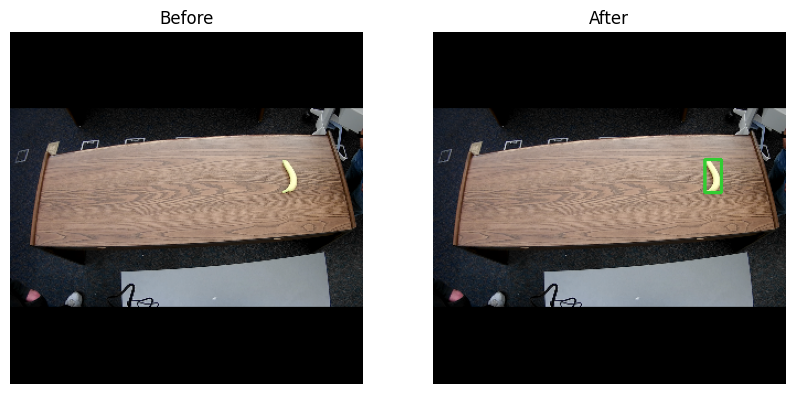

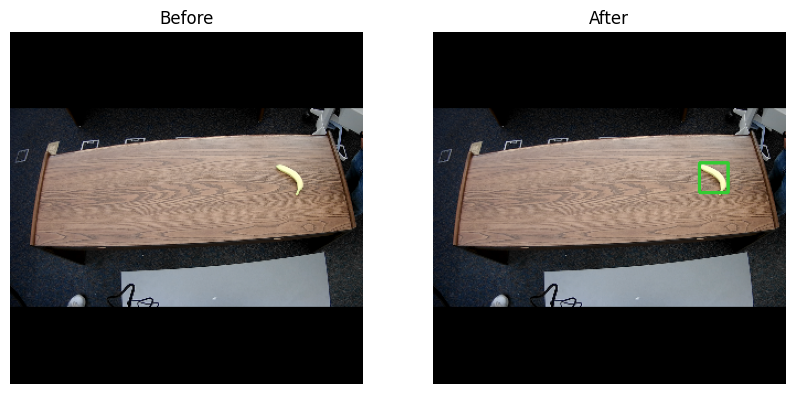

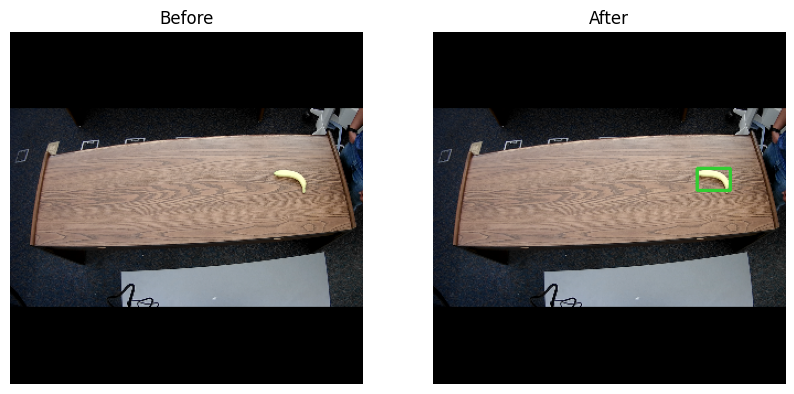

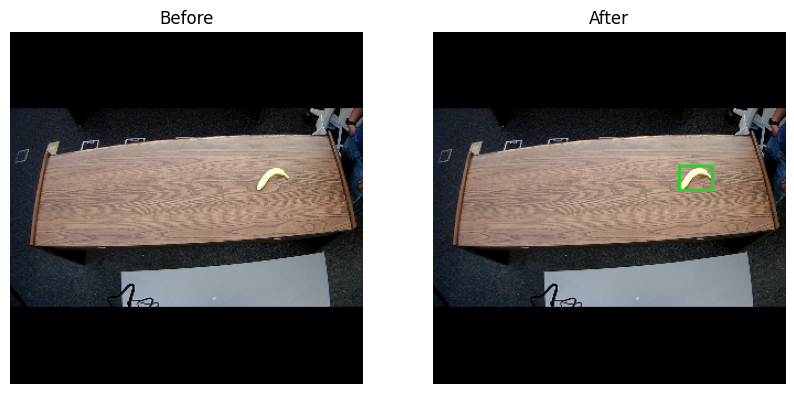

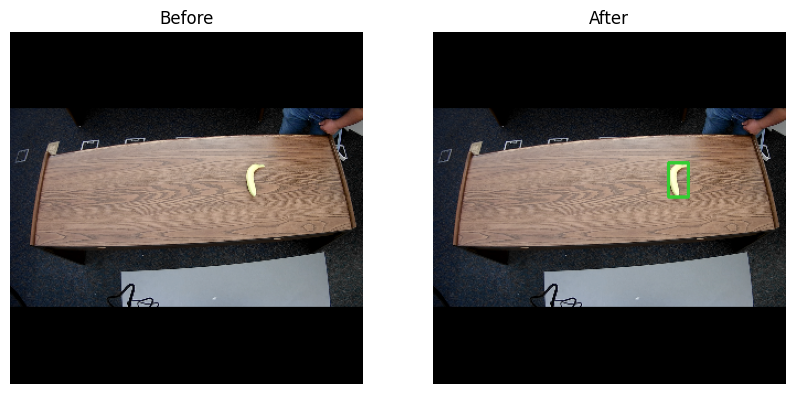

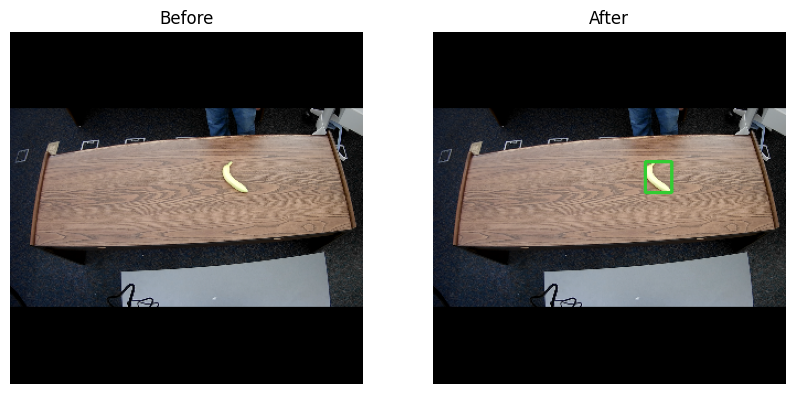

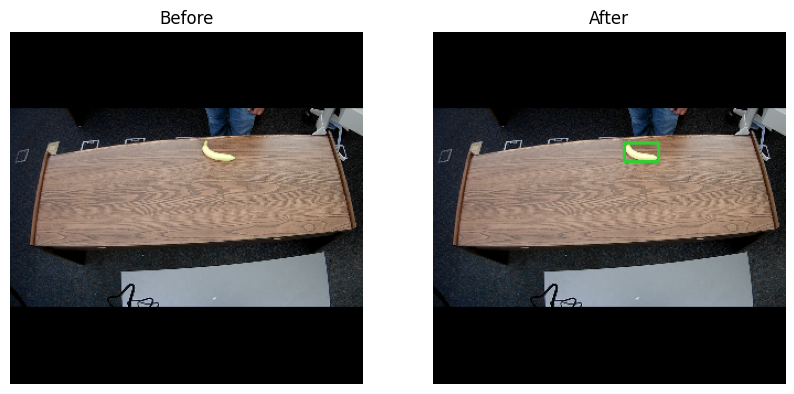

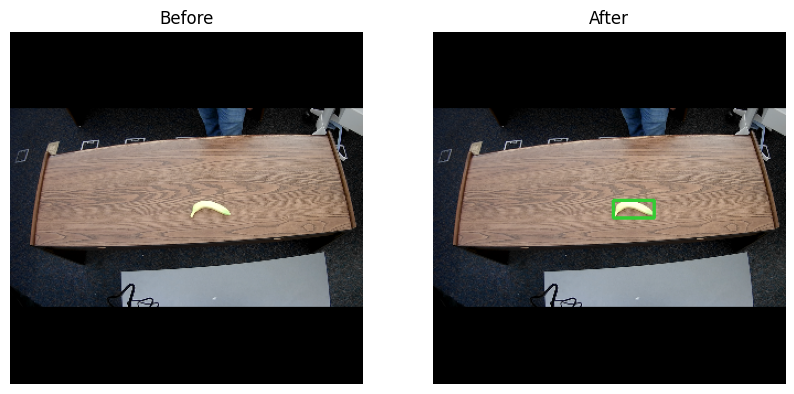

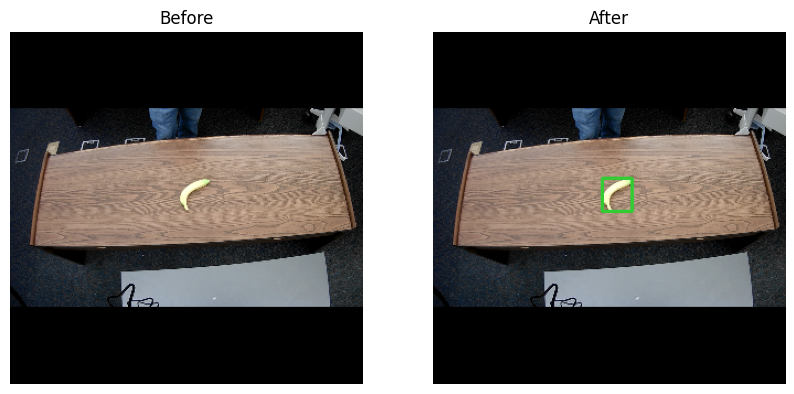

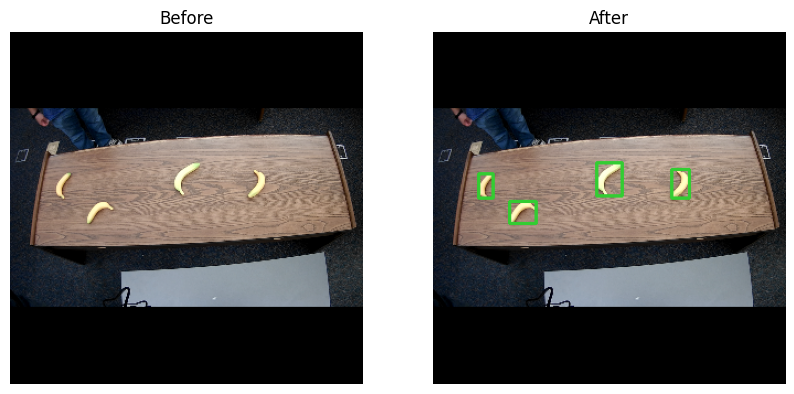

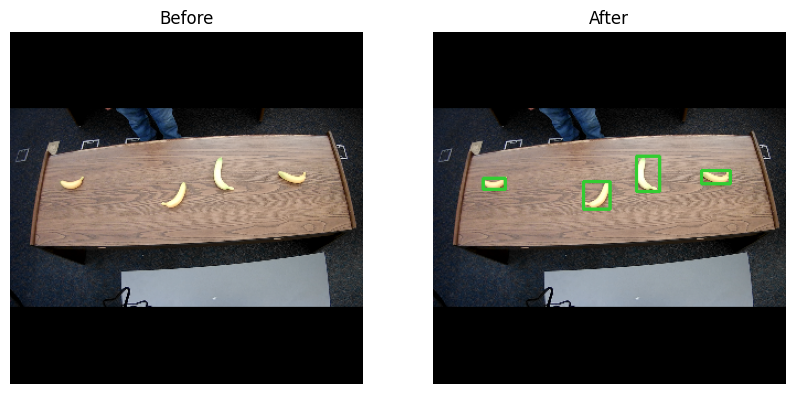

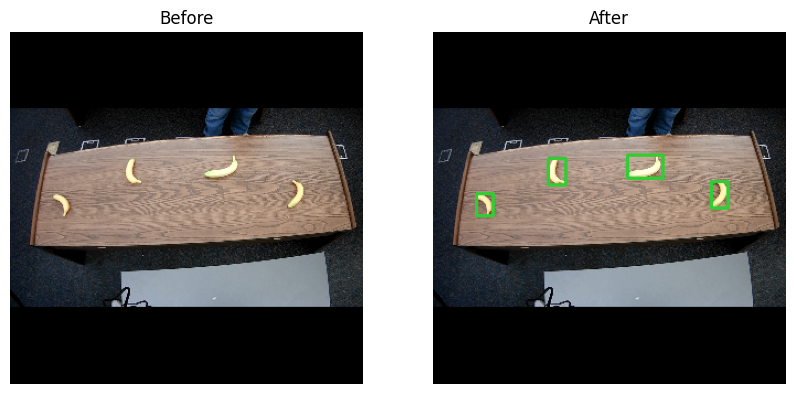

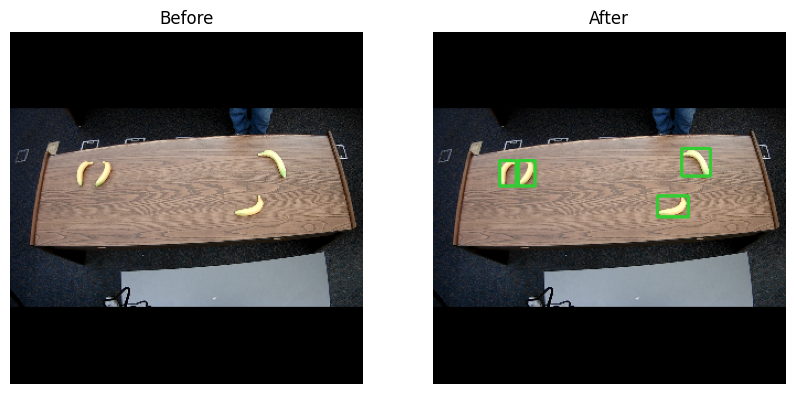

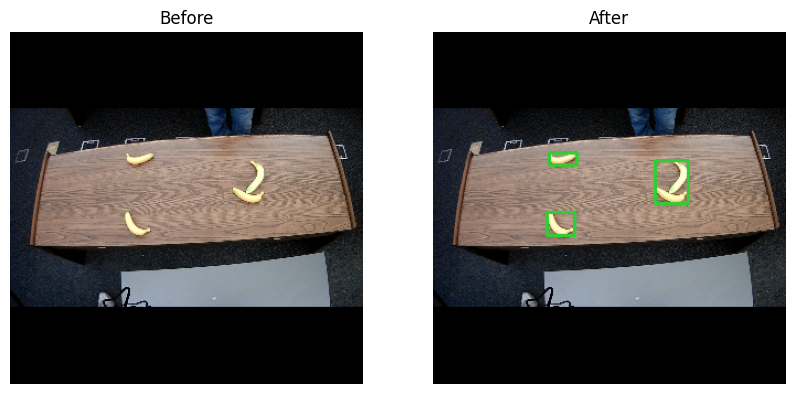

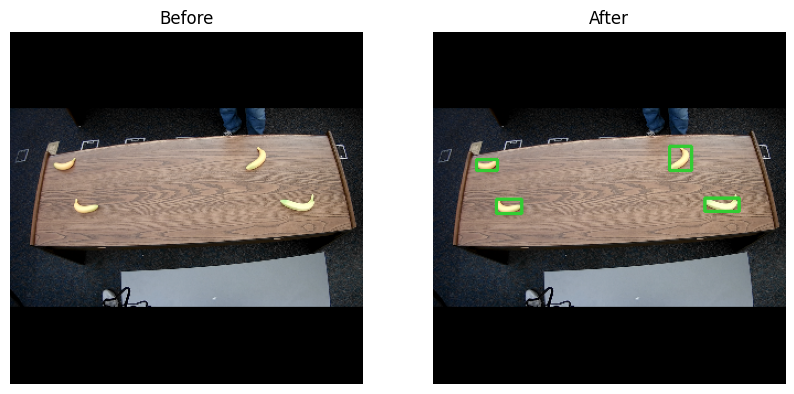

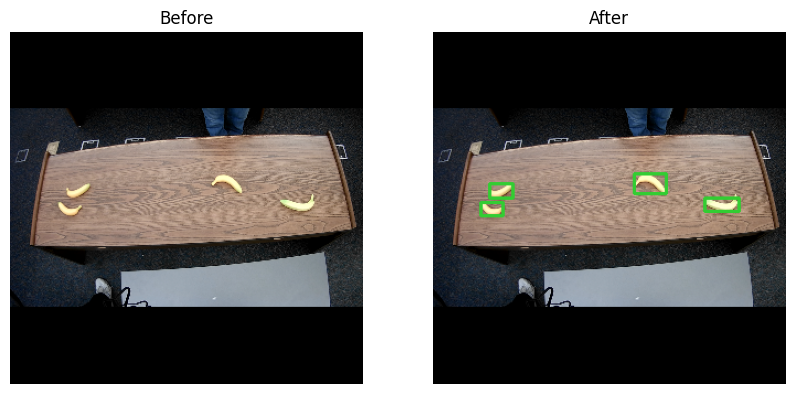

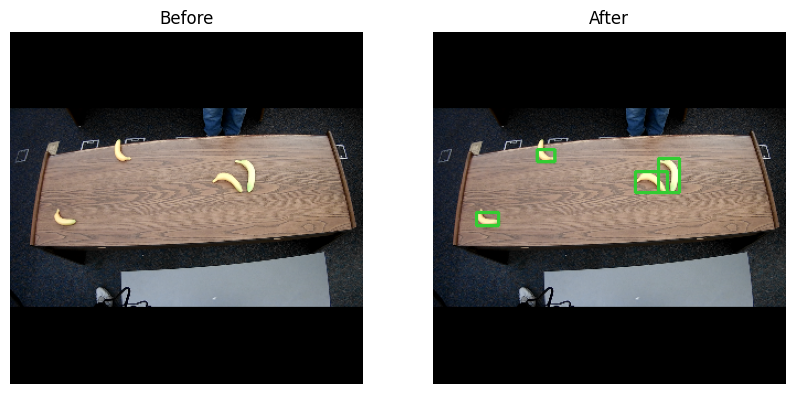

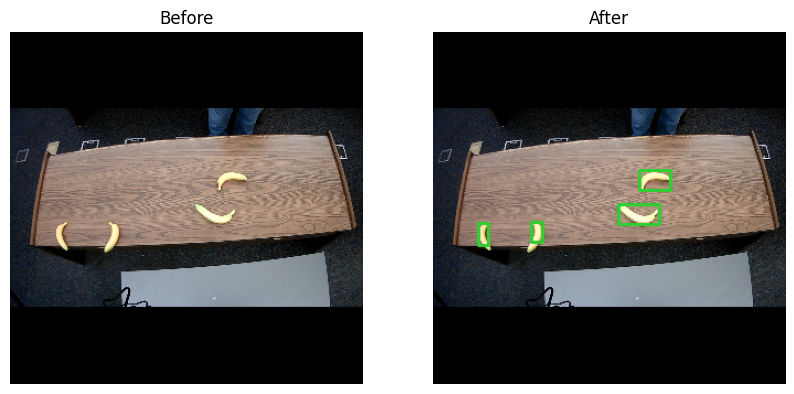

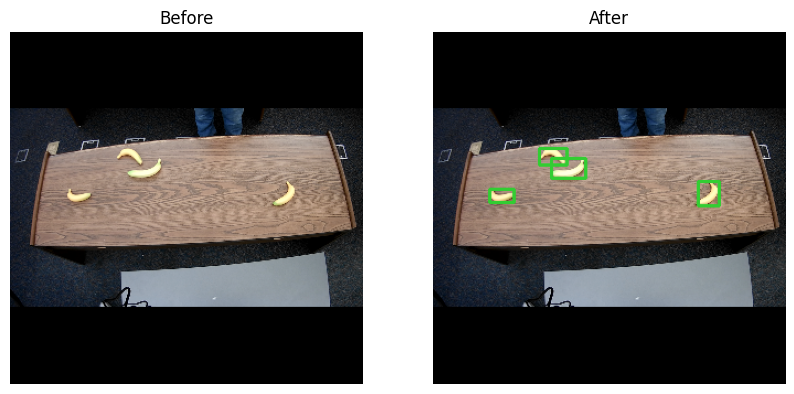

In [32]:
# Iterate through all files in the directory
count = 0
for filename in os.listdir(loadpath):
    if filename.endswith('.png'):

        processingImage(filename)
        count += 1

        print(count, "images processed...", filename)

print("Done!")

# Testing Images

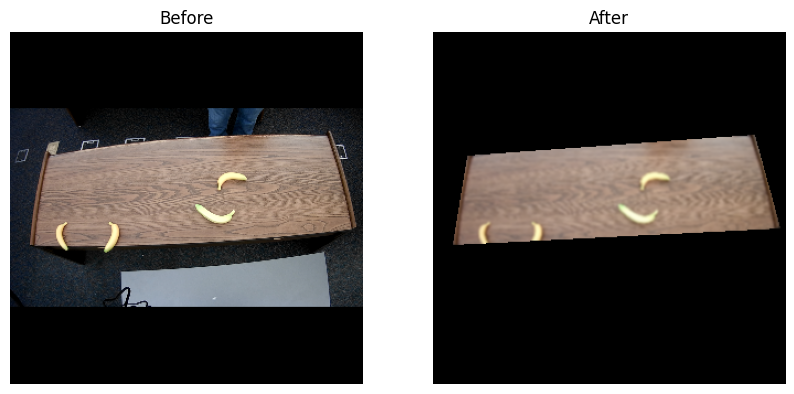

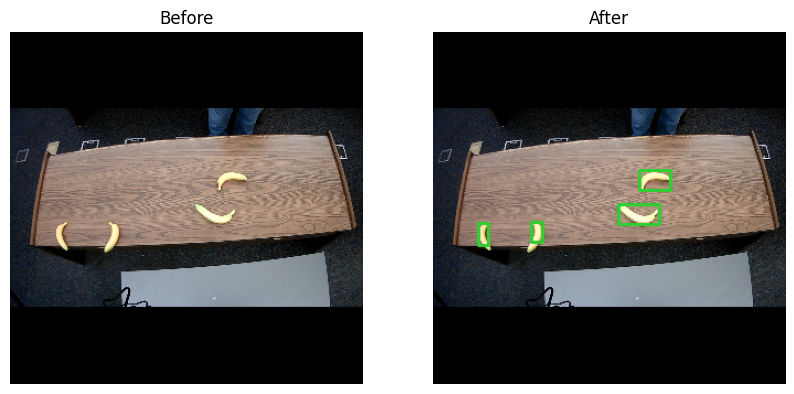

In [18]:
imgPath = "bananas508.png"

# Resizing and blurring the original image
resized = resize(imgPath)
blur = cv.GaussianBlur(resized, (5,5), 0) # This makes it easier for the next steps to work

# Removes BG
justTable = removeSurroundings(blur)
showImages(resized, justTable)

# Gets bounding box coords
boxes = findItem(resized, justTable)


In [26]:
###############################
# NOW, THE IMAGE MANIPULATION #
###############################
# Flips the boxes for output
allBoxes = flipBoxes(boxes)

# Manipulates and multiplies the images
imagesMult = multiplyImages(resized)
#    showManipulatedImages(images)

In [27]:
# Saves the altered images and writes their bounding box coords
count = saveAndWrite(imagesMult, allBoxes, imgPath)
#   print("SAVED", count, "IMAGES")

# Test displays bounding boxes on new images
imgTests = testBoxes(imagesMult, allBoxes)
#  showManipulatedImages(imgTests)